In [1]:
import warnings
warnings.filterwarnings("ignore")
import requests
import pandas as pd
import numpy as np

def get_race_result(season_number, year ):
    api = 'http://ergast.com/api/f1/{}/{}/qualifying.json'.format(year, season_number)
    data = requests.get(api).json()
    temp_df =  pd.DataFrame.from_records(data.get('MRData').get('RaceTable').get('Races')[0].get('QualifyingResults'))
    temp_df['seasonNbr'] = season_number
    temp_df['year'] = year
    return temp_df

results = []
seasons = np.arange(2003,2018,1)
rounds = np.arange(1,15,1)
for s in seasons:
    for r in rounds:
        result = get_race_result(r, s)
        results.append(result)

out = pd.concat(results, axis=0)
out['driver_id']=out.Driver.map(lambda x: x.get('driverId'))
out['car_make']=out.Constructor.map(lambda x: x.get('name'))
out['driver_nat']=out.Driver.map(lambda x: x.get('nationality'))

In [2]:
df=out[['driver_id','year','seasonNbr','position','car_make','driver_nat']]

In [3]:
def get_race_results(season_number, year ):
    api_1 = 'http://ergast.com/api/f1/{}/{}/results.json'.format(year, season_number)
    data_1 = requests.get(api_1).json()
                                         #resp.get('MRData').get('RaceTable').get('Races')[0].get('Results')
    temp_df_1 =  pd.DataFrame.from_records(data_1.get('MRData').get('RaceTable').get('Races')[0].get('Results'))
    circuit_1=data_1.get('MRData').get('RaceTable').get('Races')[0].get('Circuit')
    temp_df_1['circuit_name']=circuit_1.get('circuitName')
    temp_df_1['seasonNbr'] = season_number
    temp_df_1['year'] = year
    return temp_df_1

results_1 = []
seasons_1 = np.arange(2003,2018,1)
rounds_1 = np.arange(1,15,1)
for s in seasons_1:
    for r in rounds_1:
        result_1 = get_race_results(r, s)
        results_1.append(result_1)

outs = pd.concat(results_1, axis=0)
outs['driver_id']=outs.Driver.map(lambda x: x.get('driverId'))
outs['car_make']=outs.Constructor.map(lambda x: x.get('name'))
outs['driver_nat']=outs.Driver.map(lambda x: x.get('nationality'))\

df_1=outs[['driver_id','year','seasonNbr','position','car_make','driver_nat']]



In [43]:
# qual=df.loc[df['position'].isin(['1','2','3','4','5'])]
# race=df_1.loc[df_1['position'].isin(['1','2','3','4','5'])]
# hope=pd.concat([qual,race],axis=1)
# cold=hope[['driver_id','position','year']]
# cold.columns=['driver_race','driver_qual','pos_race','pos_qual','year1','year2']
# cold['pos_race']=cold['pos_race'].astype(int)
# cold['pos_qual']=cold['pos_qual'].astype(int)
# cold
# print(len(cold.loc[(cold['driver_race'] ==cold['driver_qual'])&(cold['pos_race']==1)]))
# print(len(cold.loc[(cold['driver_race'] ==cold['driver_qual'])&(cold['pos_race']==2)]))
# print(len(cold.loc[(cold['driver_race'] ==cold['driver_qual'])&(cold['pos_race']==3)]))
# print(len(cold.loc[(cold['driver_race'] ==cold['driver_qual'])&(cold['pos_race']==4)]))
# print(len(cold.loc[(cold['driver_race'] ==cold['driver_qual'])&(cold['pos_race']==5)]))

In [4]:
# join on driver_id, year, seasonNbrear
new_df = pd.merge(df, df_1,  how='outer', 
                  left_on=['driver_id','year', 'seasonNbr'], 
                  right_on = ['driver_id','year', 'seasonNbr'],
                 suffixes=('qual', 'actual')) # what frame the col came from since they have similar names

In [5]:
# for any rows where position actual is in [1,2,3]. what is qual position?
from collections import Counter

# c = Counter(l)
# [(i, c[i] / len(l) * 100.0) for i in c]

def compute_pcts(positions_list):
    c = Counter(positions_list)
    return [(i, c[i] / len(positions_list) * 100.0) for i in c]


# now for each elementi n the list i would like a dict of the position and its frequency

outd = new_df.groupby('positionqual')['positionactual'].apply(list).to_frame()
outd['pct_occ'] = outd.positionactual.map(compute_pcts)


temp = outd.reset_index().sort_values(by='positionqual')
temp.positionqual = temp.positionqual.astype(int)
temp.sort_values(by='positionqual', inplace=True)

In [6]:
idk=[]
snow=[]
for index, row in temp.iterrows():
    temp_var = 0
    for race_pos, pct_outcome in sorted(row.pct_occ, key=lambda x: x[1], reverse=True):
        if eval(race_pos) < 4:
            print("Qual Pos", row.positionqual, "|", "Race Pos", race_pos, "|", pct_outcome)
            temp_var += pct_outcome
            snw = (row.positionqual, f'Top {race_pos}', temp_var)
            snow.append(snw)
    idk.append(temp_var)
    print(temp_var)
    print()

Qual Pos 1 | Race Pos 1 | 53.333333333333336
Qual Pos 1 | Race Pos 2 | 15.714285714285714
Qual Pos 1 | Race Pos 3 | 10.0
79.04761904761905

Qual Pos 2 | Race Pos 1 | 21.428571428571427
Qual Pos 2 | Race Pos 2 | 20.952380952380953
Qual Pos 2 | Race Pos 3 | 15.714285714285714
58.095238095238095

Qual Pos 3 | Race Pos 2 | 20.476190476190474
Qual Pos 3 | Race Pos 3 | 17.142857142857142
Qual Pos 3 | Race Pos 1 | 10.0
47.61904761904762

Qual Pos 4 | Race Pos 2 | 14.285714285714285
Qual Pos 4 | Race Pos 3 | 12.857142857142856
Qual Pos 4 | Race Pos 1 | 5.238095238095238
32.38095238095238

Qual Pos 5 | Race Pos 3 | 12.857142857142856
Qual Pos 5 | Race Pos 2 | 9.047619047619047
Qual Pos 5 | Race Pos 1 | 2.857142857142857
24.761904761904763

Qual Pos 6 | Race Pos 3 | 10.476190476190476
Qual Pos 6 | Race Pos 2 | 4.761904761904762
Qual Pos 6 | Race Pos 1 | 2.380952380952381
17.619047619047617

Qual Pos 7 | Race Pos 2 | 5.238095238095238
Qual Pos 7 | Race Pos 3 | 4.285714285714286
Qual Pos 7 | Race 

In [7]:
import matplotlib.pyplot as plt
print(plt.bar(temp['positionqual'],idk))
plt.xlabel('Qualifying position')
plt.ylabel('% finish top 3')
plt.title('Qualifying Position vs. Top 3 Finish %')
plt.savefig('Top_3.png')

<BarContainer object of 24 artists>


In [8]:
ik=[]
for index, row in temp.iterrows():
    temp_var_1 = 0
    for race_pos, pct_outcome in sorted(row.pct_occ, key=lambda x: x[1], reverse=True):
        if eval(race_pos) < 2:
            print("Qual Pos", row.positionqual, "|", "Race Pos", race_pos, "|", pct_outcome)
            #temp_var += pct_outcome
            ik.append(pct_outcome)
    #print(temp_var)
    print()


Qual Pos 1 | Race Pos 1 | 53.333333333333336

Qual Pos 2 | Race Pos 1 | 21.428571428571427

Qual Pos 3 | Race Pos 1 | 10.0

Qual Pos 4 | Race Pos 1 | 5.238095238095238

Qual Pos 5 | Race Pos 1 | 2.857142857142857

Qual Pos 6 | Race Pos 1 | 2.380952380952381

Qual Pos 7 | Race Pos 1 | 1.9047619047619049

Qual Pos 8 | Race Pos 1 | 0.4761904761904762

Qual Pos 9 | Race Pos 1 | 0.4761904761904762

Qual Pos 10 | Race Pos 1 | 0.9523809523809524

Qual Pos 11 | Race Pos 1 | 0.9523809523809524
















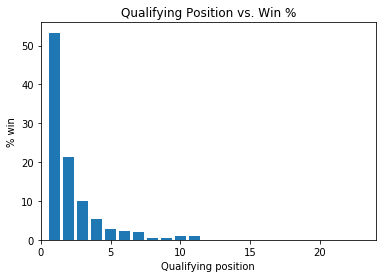

In [9]:
num=[1,2,3,4,5,6,7,8,9,10,11]
plt.bar(num,ik)
plt.xlabel('Qualifying position')
plt.ylabel('% win')
plt.xlim(0, 24)
plt.title('Qualifying Position vs. Win %')
plt.savefig('Win%.png')

In [10]:
top_3_df = pd.DataFrame.from_records(snow)
top_3_df.columns = ['Qual Position','Race Position','Percent Finish']
top_3_df.to_csv('Top_3_df.csv')


In [12]:
dk=[]
for index, row in temp.iterrows():
    temp_var_2 = 0
    for race_pos, pct_outcome in sorted(row.pct_occ, key=lambda x: x[1], reverse=True):
        if eval(race_pos) == 2:
            print("Qual Pos", row.positionqual, "|", "Race Pos", race_pos, "|", pct_outcome)
            #temp_var += pct_outcome
            dk.append(pct_outcome)
    #print(temp_var)
    print()

Qual Pos 1 | Race Pos 2 | 15.714285714285714

Qual Pos 2 | Race Pos 2 | 20.952380952380953

Qual Pos 3 | Race Pos 2 | 20.476190476190474

Qual Pos 4 | Race Pos 2 | 14.285714285714285

Qual Pos 5 | Race Pos 2 | 9.047619047619047

Qual Pos 6 | Race Pos 2 | 4.761904761904762

Qual Pos 7 | Race Pos 2 | 5.238095238095238

Qual Pos 8 | Race Pos 2 | 0.9523809523809524

Qual Pos 9 | Race Pos 2 | 2.380952380952381

Qual Pos 10 | Race Pos 2 | 1.9047619047619049

Qual Pos 11 | Race Pos 2 | 1.9047619047619049


Qual Pos 13 | Race Pos 2 | 0.4761904761904762

Qual Pos 14 | Race Pos 2 | 0.4761904761904762



Qual Pos 17 | Race Pos 2 | 0.9523809523809524


Qual Pos 19 | Race Pos 2 | 0.4830917874396135








In [13]:
di=[]
for index, row in temp.iterrows():
    temp_var_3 = 0
    for race_pos, pct_outcome in sorted(row.pct_occ, key=lambda x: x[1], reverse=True):
        if eval(race_pos) == 3:
            print("Qual Pos", row.positionqual, "|", "Race Pos", race_pos, "|", pct_outcome)
            #temp_var += pct_outcome
            di.append(pct_outcome)
    #print(temp_var)
    print()

Qual Pos 1 | Race Pos 3 | 10.0

Qual Pos 2 | Race Pos 3 | 15.714285714285714

Qual Pos 3 | Race Pos 3 | 17.142857142857142

Qual Pos 4 | Race Pos 3 | 12.857142857142856

Qual Pos 5 | Race Pos 3 | 12.857142857142856

Qual Pos 6 | Race Pos 3 | 10.476190476190476

Qual Pos 7 | Race Pos 3 | 4.285714285714286

Qual Pos 8 | Race Pos 3 | 3.3333333333333335

Qual Pos 9 | Race Pos 3 | 0.4761904761904762

Qual Pos 10 | Race Pos 3 | 2.857142857142857

Qual Pos 11 | Race Pos 3 | 1.9047619047619049

Qual Pos 12 | Race Pos 3 | 0.4761904761904762

Qual Pos 13 | Race Pos 3 | 1.9047619047619049


Qual Pos 15 | Race Pos 3 | 0.9523809523809524

Qual Pos 16 | Race Pos 3 | 0.9523809523809524

Qual Pos 17 | Race Pos 3 | 0.4761904761904762

Qual Pos 18 | Race Pos 3 | 0.4761904761904762

Qual Pos 19 | Race Pos 3 | 0.966183574879227

Qual Pos 20 | Race Pos 3 | 0.49261083743842365

Qual Pos 21 | Race Pos 3 | 1.7241379310344827

Qual Pos 22 | Race Pos 3 | 0.8928571428571428





In [66]:
# N=22
# ind = np.arange(N)
# p1 = plt.bar(ind, ik)
# p2 = plt.bar(ind, dk)             
# p3 = plt.bar(ind, di)
len(di)
dk=dk+[0]*(len(di)-len(dk))
ik=ik+[0]*(len(di)-len(ik))
N=21
ind = np.arange(N) 

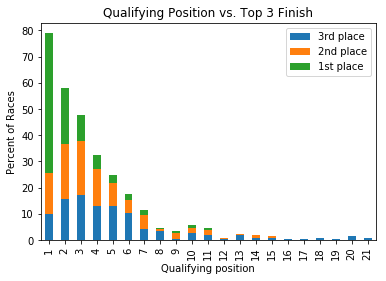

In [73]:
oh=pd.DataFrame(data=di)
oh['a']=dk
oh['b']=ik
oh.columns = ['3rd place','2nd place','1st place']
oh.plot(kind='bar', stacked=True)
plt.xlabel('Qualifying position')
plt.xticks(ind,('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21'))
plt.ylabel('Percent of Races')
plt.title('Qualifying Position vs. Top 3 Finish')
plt.savefig('Stacked_finish.png')

In [74]:
idk

[79.04761904761905,
 58.095238095238095,
 47.61904761904762,
 32.38095238095238,
 24.761904761904763,
 17.619047619047617,
 11.428571428571429,
 4.761904761904762,
 3.3333333333333335,
 5.714285714285714,
 4.761904761904762,
 0.4761904761904762,
 2.380952380952381,
 0.4761904761904762,
 0.9523809523809524,
 0.9523809523809524,
 1.4285714285714286,
 0.4761904761904762,
 1.4492753623188406,
 0.49261083743842365,
 1.7241379310344827,
 0.8928571428571428,
 0,
 0]